# 3D Shape Recognition

# Importing Libraries

In [2]:
# important libraries used in the task
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from PIL import Image
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline
from sklearn.model_selection import train_test_split

In [3]:
# reading a random image
image = Image.open('modified_ShapeNet/Train/Image_000001_001.jpg')

In [4]:
# checking attributes of an image 
print(image.format)
print(image.mode)
print(image.size)

JPEG
RGB
(64, 64)


As shown above,our dataset contains RGB images with size of 64x64

(64, 64, 3)


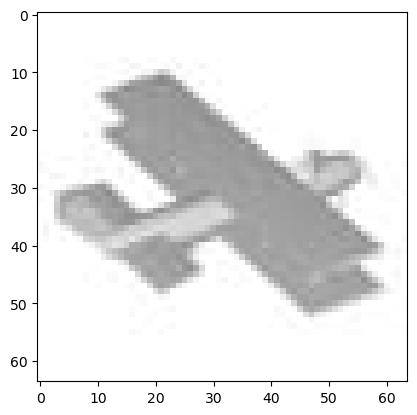

In [5]:
# getting image as an array and displaying 
print(np.asarray(image).shape)
imshow(np.asarray(image))

# Data Generator

In [6]:

class Custom_data_generator(tf.keras.utils.Sequence):
    # init function which has dataframe, target column, x column, input image size and shuffle of 
    #images as parameters 
    def __init__(self, dataframe, x_col, y_col,
                 batch_size =16,
                 input_size=(64, 64, 3),
                 shuffle=True):
        
        self.dataframe = dataframe.copy()
        self.x_col = x_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        
        self.n = len(self.dataframe)
        self.n_name = dataframe[y_col['label']].nunique()
    
    def on_epoch_end(self):
        if self.shuffle:
            self.dataframe = self.dataframe.sample(frac=1).reset_index(drop=True)
     #function that takes paths of all views and target image size as parameters and scaling them 
    # in range of [0,1]
    def __get_input(self, path,path1,path2,path3, target_size):
        #path ='modified_ShapeNet/Train/'
        #reading 1st View and converting to array
        image = tf.keras.preprocessing.image.load_img(path)
        image_array = tf.keras.preprocessing.image.img_to_array(image)
        image_array = tf.image.resize(image_array,(target_size[0], target_size[1])).numpy()
        #reading 2nd View and converting to array
        image1 = tf.keras.preprocessing.image.load_img(path1)
        image_array1 = tf.keras.preprocessing.image.img_to_array(image1)
        image_array1 = tf.image.resize(image_array1,(target_size[0], target_size[1])).numpy()
        #reading 3rd View and converting to array
        image2 = tf.keras.preprocessing.image.load_img(path2)
        image_array2 = tf.keras.preprocessing.image.img_to_array(image2)
        image_array2 = tf.image.resize(image_array2,(target_size[0], target_size[1])).numpy()
        #reading 4th View and converting to array
        image3 = tf.keras.preprocessing.image.load_img(path3)
        image_array3 = tf.keras.preprocessing.image.img_to_array(image3)
        image_array3 = tf.image.resize(image_array3,(target_size[0], target_size[1])).numpy()
        
        return image_array/255.,image_array1/255.,image_array2/255.,image_array3/255.
    # function to get the output label
    def __get_output(self, label, num_classes):
        return tf.keras.utils.to_categorical(label, num_classes=num_classes)
    # function to get the data in batches 
    def __get_data(self, batches):
        path_batch = batches[self.x_col['path']]
        path_batch1 = batches[self.x_col['path1']]
        path_batch2 = batches[self.x_col['path2']]
        path_batch3 = batches[self.x_col['path3']]
        name_batch = batches[self.y_col['label']]

        X_batch = np.asarray([self.__get_input(x,y,z,j, self.input_size) for x,y,z,j  in zip(path_batch,path_batch1,path_batch2,path_batch3)])

        y0_batch = np.asarray([self.__get_output(y, self.n_name) for y in name_batch])

        return X_batch,y0_batch
    
    def __getitem__(self, index):
        batches = self.dataframe[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)        
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size

In [7]:
#loading the train data
train_data_df = pd.read_csv('Data.csv')
train_data_df.head()

,View1,View2,View3,View4,label
0,Image_000001_001.jpg,Image_000001_002.jpg,Image_000001_003.jpg,Image_000001_004.jpg,airplane
1,Image_000002_001.jpg,Image_000002_002.jpg,Image_000002_003.jpg,Image_000002_004.jpg,airplane
2,Image_000003_001.jpg,Image_000003_002.jpg,Image_000003_003.jpg,Image_000003_004.jpg,airplane
3,Image_000004_001.jpg,Image_000004_002.jpg,Image_000004_003.jpg,Image_000004_004.jpg,airplane
4,Image_000005_001.jpg,Image_000005_002.jpg,Image_000005_003.jpg,Image_000005_004.jpg,airplane


In [8]:
train_data_df.shape

(30530, 5)

In [9]:
train_data_df['label'].value_counts()

table          5876
chair          4612
airplane       2832
car            2502
sofa           2198
rifle          1655
lamp           1620
watercraft     1356
bench          1260
loudspeaker    1116
cabinet        1076
display         762
bus             628
bathtub         599
guitar          557
faucet          519
jar             380
bottle          340
telephone       323
laptop          319
Name: label, dtype: int64

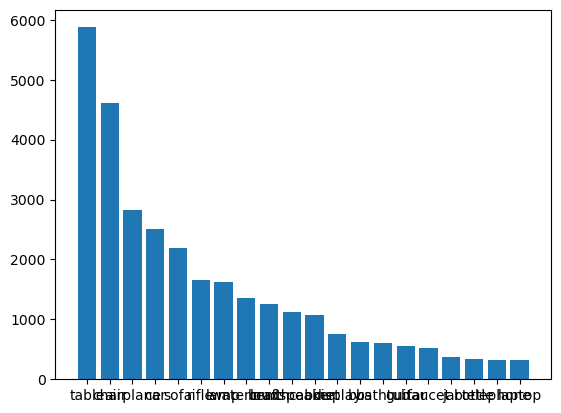

In [10]:
#plotting the distribution of classes 
plt.bar(train_data_df['label'].value_counts().index,train_data_df['label'].value_counts().values)
plt.show()

From above figure we can see that the classes are enevenly distributed

In [11]:
#function to add path to images 
def append_path_images(text):
    return 'modified_ShapeNet/Train/'+text

In [12]:
# applying path to all the column 
train_data_df['View1'] = train_data_df['View1'].apply(lambda text:append_path_images(text))
train_data_df['View2'] = train_data_df['View2'].apply(lambda text:append_path_images(text))
train_data_df['View3'] = train_data_df['View3'].apply(lambda text:append_path_images(text))
train_data_df['View4'] = train_data_df['View4'].apply(lambda text:append_path_images(text))


In [13]:
# replacing the target values with categorical int values
replace_dictionary = {"airplane": 0, "table": 1, "chair": 2, "car":3,"sofa":4,"rifle":5,"lamp":6,
                "watercraft":7,"bench":8,"loudspeaker":9,"cabinet":10,"display":11,"bus":12,"bathtub":13,
               "guitar":14,"faucet":15,"jar":16,"bottle":17,"telephone":18,"laptop":19}




In [14]:
train_data_df.label.replace(replace_dictionary,inplace=True)

In [15]:
train_data_df.head()

,View1,View2,View3,View4,label
0,modified_ShapeNet/Train/Image_000001_001.jpg,modified_ShapeNet/Train/Image_000001_002.jpg,modified_ShapeNet/Train/Image_000001_003.jpg,modified_ShapeNet/Train/Image_000001_004.jpg,0
1,modified_ShapeNet/Train/Image_000002_001.jpg,modified_ShapeNet/Train/Image_000002_002.jpg,modified_ShapeNet/Train/Image_000002_003.jpg,modified_ShapeNet/Train/Image_000002_004.jpg,0
2,modified_ShapeNet/Train/Image_000003_001.jpg,modified_ShapeNet/Train/Image_000003_002.jpg,modified_ShapeNet/Train/Image_000003_003.jpg,modified_ShapeNet/Train/Image_000003_004.jpg,0
3,modified_ShapeNet/Train/Image_000004_001.jpg,modified_ShapeNet/Train/Image_000004_002.jpg,modified_ShapeNet/Train/Image_000004_003.jpg,modified_ShapeNet/Train/Image_000004_004.jpg,0
4,modified_ShapeNet/Train/Image_000005_001.jpg,modified_ShapeNet/Train/Image_000005_002.jpg,modified_ShapeNet/Train/Image_000005_003.jpg,modified_ShapeNet/Train/Image_000005_004.jpg,0


In [16]:
#saving the images with path 
train_data_df.to_csv('train_data.csv')

In [17]:

# splitting the train data set into train and validation set    
with pd.option_context('mode.chained_assignment', None):
    train_data, val_data = train_test_split(train_data_df, test_size=0.25, shuffle=True,random_state=0)
    
print(train_data.shape[0], val_data.shape[0])

22897 7633


In [20]:
# Applying custom data generator to train data
traingen = Custom_data_generator(train_data,
                         x_col={'path':'View1','path1':'View2','path2':'View3','path3':'View4'},
                         y_col={'label': 'label'},
                         batch_size=16, input_size=(64,64,3))

In [21]:
# Applying custom data generator to validation data
validgen = Custom_data_generator(val_data,
                         x_col={'path':'View1','path1':'View2','path2':'View3','path3':'View4'},
                         y_col={'label': 'label'},
                         batch_size=16, input_size=(64,64,3))

In [22]:
print("validation generator length: "+str(validgen.__len__()))
print("train generator length: "+str(traingen.__len__()))

validation generator length: 477
train generator length: 1431


In [23]:
# getting shape of the train generator
for x,y in traingen.__iter__():
    print(x.shape,y.shape)

2022-09-09 19:32:16.120633: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (

(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (

(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (

(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (

(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (16, 20)
(16, 4, 64, 64, 3) (

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling3D, Lambda, Input
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers

def get_model():
  model_cnn = Sequential()

  # input
  model_cnn.add(Input(shape=(4,64, 64, 3)))

  # Conv Layer 1
  model_cnn.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
  model_cnn.add(Activation('relu'))
  model_cnn.add(MaxPooling3D(pool_size=(2, 2,2)))

  # Conv Layer 2 (no pooling)
  model_cnn.add(Conv2D(64, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
  model_cnn.add(Activation('relu'))
  model_cnn.add(MaxPooling3D(pool_size=(2, 2,2)))

  # Conv Layer 3
  model_cnn.add(Conv2D(64, (3, 3)))
  model_cnn.add(Activation('relu'))

  model_cnn.add(Flatten())  
  model_cnn.add(Dropout(0.5))
  model_cnn.add(Dense(64))
  model_cnn.add(Activation('relu'))
  model_cnn.add(Dense(20))
  model_cnn.add(Activation('softmax'))

  
  return model_cnn

In [25]:
# compiling model with optimizer RMSprop
model = get_model()
model.compile(optimizer=RMSprop(lr=0.001),
                         loss='CategoricalCrossentropy',
                         metrics =['accuracy'])

/Users/sunny/opt/anaconda3/envs/env_tf/lib/python3.9/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [27]:
#printing model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 4, 62, 62, 32)     896       
                                                                 
 activation (Activation)     (None, 4, 62, 62, 32)     0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 2, 31, 31, 32)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 29, 29, 64)     18496     
                                                                 
 activation_1 (Activation)   (None, 2, 29, 29, 64)     0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 1, 14, 14, 64)    0         
 3D)                                                    

In [28]:
history = model.fit(traingen,verbose=1, validation_data=validgen,
                                         steps_per_epoch=100,
                                         epochs=15,
                                         validation_steps=50)

Epoch 1/15
100/100 [==============================] - 17s 164ms/step - loss: 2.6795 - accuracy: 0.2225 - val_loss: 2.3417 - val_accuracy: 0.3988
Epoch 2/15
100/100 [==============================] - 16s 162ms/step - loss: 1.7638 - accuracy: 0.5088 - val_loss: 1.4772 - val_accuracy: 0.5587
Epoch 3/15
100/100 [==============================] - 16s 161ms/step - loss: 1.3669 - accuracy: 0.6056 - val_loss: 1.0624 - val_accuracy: 0.6812
Epoch 4/15
100/100 [==============================] - 16s 161ms/step - loss: 1.1133 - accuracy: 0.6631 - val_loss: 0.9254 - val_accuracy: 0.7513
Epoch 5/15
100/100 [==============================] - 16s 158ms/step - loss: 1.0170 - accuracy: 0.7050 - val_loss: 1.0271 - val_accuracy: 0.7025
Epoch 6/15
100/100 [==============================] - 16s 158ms/step - loss: 1.0215 - accuracy: 0.7069 - val_loss: 0.8010 - val_accuracy: 0.7675
Epoch 7/15
100/100 [==============================] - 16s 158ms/step - loss: 0.8999 - accuracy: 0.7406 - val_loss: 1.0435 - val_ac

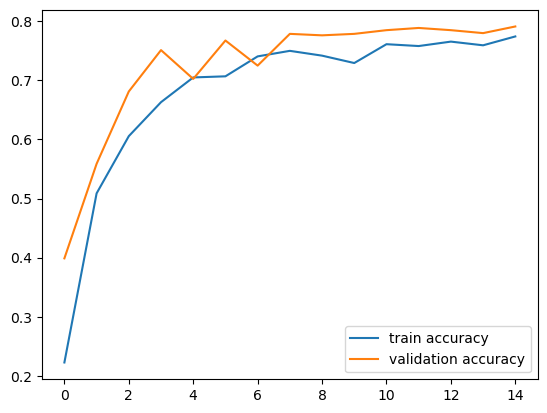

In [29]:
# accuracies 
plt.plot(history.history['accuracy'],label ='train accuracy')
plt.plot(history.history['val_accuracy'],label ='validation accuracy')
plt.legend()
plt.show()

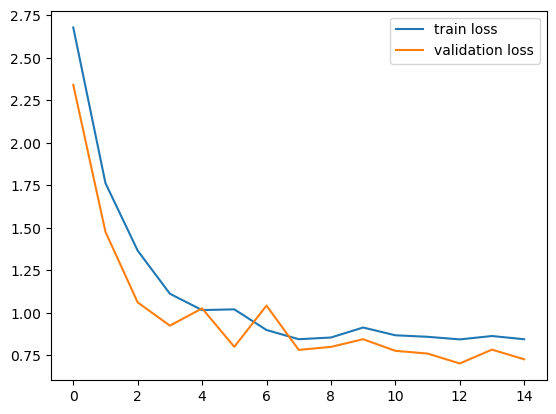

In [30]:
# loss 
plt.plot(history.history['loss'],label ='train loss')
plt.plot(history.history['val_loss'],label ='validation loss')
plt.legend()
plt.show()

# Analysis on Test Data set

In [31]:
# reading the test data set
test_data_df = pd.read_csv('test_data.csv')
test_data_df.head()

,View1,View2,View3,View4,label
0,Image_100001_001.jpg,Image_100001_002.jpg,Image_100001_003.jpg,Image_100001_004.jpg,None
1,Image_100002_001.jpg,Image_100002_002.jpg,Image_100002_003.jpg,Image_100002_004.jpg,None
2,Image_100003_001.jpg,Image_100003_002.jpg,Image_100003_003.jpg,Image_100003_004.jpg,None
3,Image_100004_001.jpg,Image_100004_002.jpg,Image_100004_003.jpg,Image_100004_004.jpg,None
4,Image_100005_001.jpg,Image_100005_002.jpg,Image_100005_003.jpg,Image_100005_004.jpg,None


In [32]:
test_data_df.shape

(4376, 5)

In [33]:
#function to append the path of image
def append_test(text):
    return 'Test/'+text 

In [34]:
# applying path to the images
test_data_df['View1'] = test_data_df['View1'].apply(lambda text:append_test(text))
test_data_df['View2'] = test_data_df['View2'].apply(lambda text:append_test(text))
test_data_df['View3'] = test_data_df['View3'].apply(lambda text:append_test(text))
test_data_df['View4'] = test_data_df['View4'].apply(lambda text:append_test(text))

In [35]:
# dropping the target label column
test_data_df.drop("label", axis=1, inplace=True)

In [36]:
test_data_df.head()

,View1,View2,View3,View4
0,Test/Image_100001_001.jpg,Test/Image_100001_002.jpg,Test/Image_100001_003.jpg,Test/Image_100001_004.jpg
1,Test/Image_100002_001.jpg,Test/Image_100002_002.jpg,Test/Image_100002_003.jpg,Test/Image_100002_004.jpg
2,Test/Image_100003_001.jpg,Test/Image_100003_002.jpg,Test/Image_100003_003.jpg,Test/Image_100003_004.jpg
3,Test/Image_100004_001.jpg,Test/Image_100004_002.jpg,Test/Image_100004_003.jpg,Test/Image_100004_004.jpg
4,Test/Image_100005_001.jpg,Test/Image_100005_002.jpg,Test/Image_100005_003.jpg,Test/Image_100005_004.jpg


In [42]:
# custom data generator for test data set
class CustomDataGentest(tf.keras.utils.Sequence):
    
    def __init__(self, df, X_col, 
                 batch_size =8,
                 input_size=(64, 64, 3),
                 shuffle=True):
        
        self.df = df.copy()
        self.X_col = X_col
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        
        self.n = len(self.df)
        #self.n_name = df[y_col['label']].nunique()
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
            
    def __get_input(self, path,path1,path2,path3, target_size):
        #path ='modified_ShapeNet/Train/'
        image = tf.keras.preprocessing.image.load_img(path)
        image_arr = tf.keras.preprocessing.image.img_to_array(image)
        image_arr = tf.image.resize(image_arr,(target_size[0], target_size[1])).numpy()
        #print(image_arr)
        image1 = tf.keras.preprocessing.image.load_img(path1)
        image_arr1 = tf.keras.preprocessing.image.img_to_array(image1)
        image_arr1 = tf.image.resize(image_arr1,(target_size[0], target_size[1])).numpy()
        
        image2 = tf.keras.preprocessing.image.load_img(path2)
        image_arr2 = tf.keras.preprocessing.image.img_to_array(image2)
        image_arr2 = tf.image.resize(image_arr2,(target_size[0], target_size[1])).numpy()
        
        image3 = tf.keras.preprocessing.image.load_img(path3)
        image_arr3 = tf.keras.preprocessing.image.img_to_array(image3)
        image_arr3 = tf.image.resize(image_arr3,(target_size[0], target_size[1])).numpy()
        
        return image_arr/255.,image_arr1/255.,image_arr2/255.,image_arr3/255.
   # def __get_output(self, label, num_classes):
    #    return tf.keras.utils.to_categorical(label, num_classes=num_classes)
    
    def __get_data(self, batches):
    # Generates data containing batch_size samples

        path_batch = batches[self.X_col['path']]
        path_batch1 = batches[self.X_col['path1']]
        path_batch2 = batches[self.X_col['path2']]
        path_batch3 = batches[self.X_col['path3']]
        

        X_batch = np.asarray([self.__get_input(x,y,z,j, self.input_size) for x,y,z,j  in zip(path_batch,path_batch1,path_batch2,path_batch3)])

       

        return X_batch
    
    def __getitem__(self, index):
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X= self.__get_data(batches)        
        return X
    
    def __len__(self):
        return self.n // self.batch_size

In [43]:
testgen = CustomDataGentest(test_data_df,
                         X_col={'path':'View1','path1':'View2','path2':'View3','path3':'View4'},
                         batch_size=8, input_size=(64,64,3))

In [44]:
print(testgen.__len__())
for x in testgen.__iter__():
    print(x.shape)

547
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4,

(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64, 64, 3)
(8, 4, 64,

In [41]:
#applying predictions on test data generator
predictions_test = model.predict(testgen)

In [45]:
print(len(predictions_test))

4376


In [46]:
print(predictions_test[0])

[2.38549336e-09 2.88779698e-02 5.24025969e-03 4.45082114e-04
 1.77982773e-04 1.57515126e-06 4.82108956e-03 2.25867916e-04
 6.15252429e-05 5.14250994e-01 3.72966170e-01 6.74066553e-03
 2.62210551e-06 2.87285936e-03 1.07314655e-07 2.74314632e-04
 5.13521247e-02 1.35540075e-04 1.15528405e-02 3.52476462e-07]


From above the probabilities of image 1 belonging to 20 classes is shown

In [47]:
class_label_test = np.argmax(predictions_test,axis=1)
print(class_label_test)

[9 6 8 ... 2 9 7]


In [48]:
#list to store prediction
cl_test=[]
for i in range(len(class_label_test)):
    cl_test.append((class_label_test[i]))

In [49]:
#list to convert int values of labels to category
result = []
for i in class_label_test:
    if class_label_test[i] == 0:
        result.append('airplane')
    elif class_label_test[i]==1:
        result.append('table')
    elif class_label_test[i]==2:
        result.append('chair')
    elif class_label_test[i]==3:
        result.append('car')
    elif class_label_test[i]==4:
        result.append('sofa')
    elif class_label_test[i]==5:
        result.append('rifle')
    elif class_label_test[i]==6:
        result.append('lamp')
    elif class_label_test[i]==7:
        result.append('watercraft')
    elif class_label_test[i]==8:
        result.append('bench')
    elif class_label_test[i]==9:
        result.append('loudspeaker')
    elif class_label_test[i]==10:
        result.append('cabinet')
    elif class_label_test[i]==11:
        result.append('display')
    elif class_label_test[i]==12:
        result.append('bus')
    elif class_label_test[i]==13:
        result.append('bathtub')
    elif class_label_test[i]==14:
        result.append('guitar')
    elif class_label_test[i]==15:
        result.append('faucet')
    elif class_label_test[i]==16:
        result.append('jar')
    elif class_label_test[i]==17:
        result.append('bottle')
    elif class_label_test[i]==18:
        result.append('telephone')
    elif class_label_test[i]==19:
        result.append('laptop')

# Importing prediction sheet

In [50]:
predictions_df = pd.read_csv('s1234567_predictions..csv')
predictions_df.head()

,Image,label
0,Image_100001,None
1,Image_100002,None
2,Image_100003,None
3,Image_100004,None
4,Image_100005,None


In [51]:
predictions_df['label'] =result

In [52]:
predictions_df.head(30)

,Image,label
0,Image_100001,chair
1,Image_100002,sofa
2,Image_100003,table
3,Image_100004,car
4,Image_100005,car
5,Image_100006,lamp
6,Image_100007,car
7,Image_100008,lamp
8,Image_100009,lamp
9,Image_100010,bench


In [53]:
predictions_df.to_csv('predictions.csv')